# Classification Demo

In this notebook, we will see how to prepare the data for classification, upload the data, start training and do inference.

### Install pyjwt library if not already installed

In [53]:
!pip install pyjwt

In [54]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
import jwt
import time
import json

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
import requests
import base64

## Prepare training and test data

We have a small dataset of service request tickets on complaints received about financial products and services. We will attempt to build a classifier which automatically classifies these tickets into their respective categories.

The below code block loads the data from file

In [56]:
df = pd.read_csv("../datasets/complaint_clean.csv")

### Let's see the data

In [57]:
df.head()

,Product,Sub-product,Issue,Sub-issue,Description,TicketID
0,"Credit reporting, credit repair services, or o...",Other personal consumer report,Improper use of your report,Reporting company used your report improperly,On XXXX XXXX XXXX 2015 Barclays Ba n...,8f634167-1466-41b6-903e-ae8406d95232
1,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,I have been receiving numerous calls from Sync...,863efe9f-1452-431e-a5e7-f1756489ec69
2,Student loan,Federal student loan servicing,Dealing with my lender or servicer,Received bad information about my loan,I have been on economic deferment since I left...,bf9b849b-c1cf-44b8-9f40-4a44a7c7cf86
3,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,XXXX and Equifax will not remove unauthorized...,2d6a58b3-efc3-4ea8-9b2c-a3fc93364db0
4,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,XXXX XXXX XXXX XXXX XXXX ( serviced by XXXX XX...,58e5c75c-98b3-4876-9f0a-16cf7236e161


### Let's select the input and output mappings for training

The mapping describes which columns in the upload file should be used as sample input and which ones are to be used as the classification output that the model should learn.

In [1]:
input_cols = ['Description']
output_cols = ['Product']
all_cols = input_cols + output_cols

### Check the data distribution

After loading the data into dataframe, we check the distribution of classes (target variable).

Usually the model works best if the dataset is balanced i.e. classes are equally distributed with little skewness, and each class has at least 1000 data points.

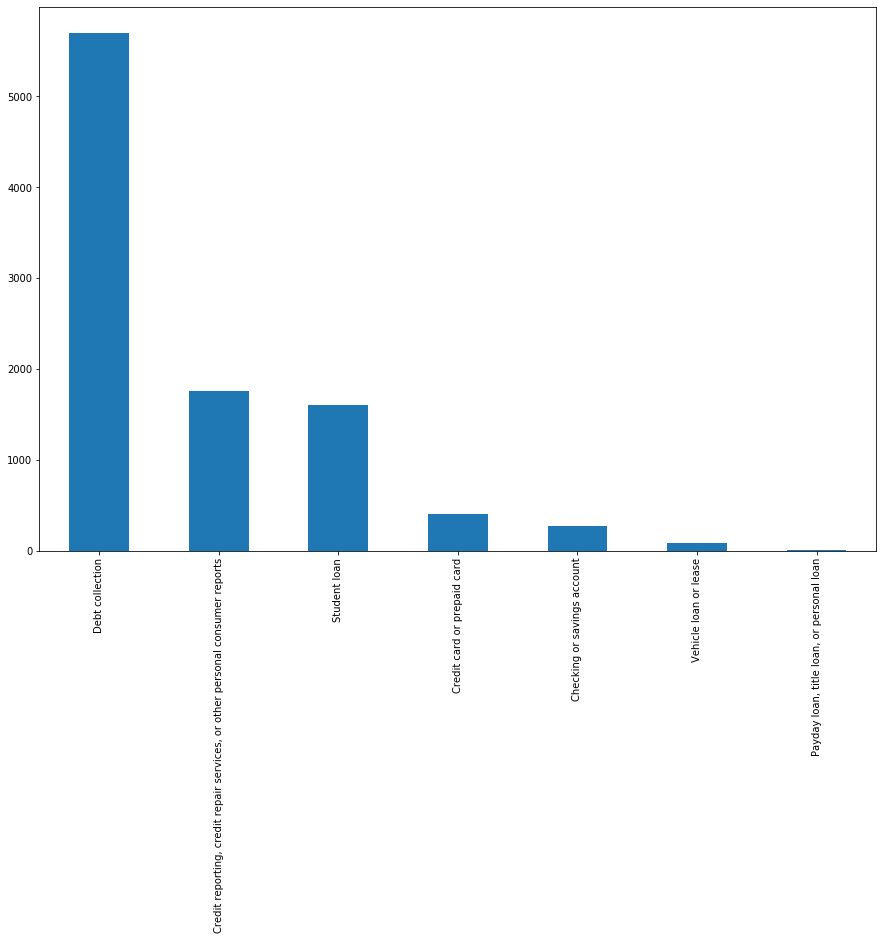

In [59]:
fig, axes = plt.subplots(nrows=len(output_cols), ncols=1, figsize=(15, 10))
for idx, output_col in enumerate(output_cols):
    distribution = df[output_col].value_counts()
    distribution.plot(kind='bar', rot=90, ax=axes[idx] if len(output_cols)!=1 else axes)

## Training, test data split

We split the loaded data into two sets
1. Data we should upload and do the training
2. Test data we use for testing the generated model

In [60]:
df_train, df_test = train_test_split(df[all_cols], test_size = 0.01, shuffle=True)

In [61]:
for output_col in output_cols:
    print(output_col)
    print("\nTraining Data:")
    print(df_train[output_col].value_counts())
    print("\nTesting Data:")
    print(df_test[output_col].value_counts())
    print("\n \n")

Product

Training Data:
Debt collection                                                                 5650
Credit reporting, credit repair services, or other personal consumer reports    1730
Student loan                                                                    1589
Credit card or prepaid card                                                      402
Checking or savings account                                                      273
Vehicle loan or lease                                                             82
Payday loan, title loan, or personal loan                                          8
Name: Product, dtype: int64

Testing Data:
Debt collection                                                                 51
Credit reporting, credit repair services, or other personal consumer reports    25
Student loan                                                                    18
Credit card or prepaid card                                                      3
Checki

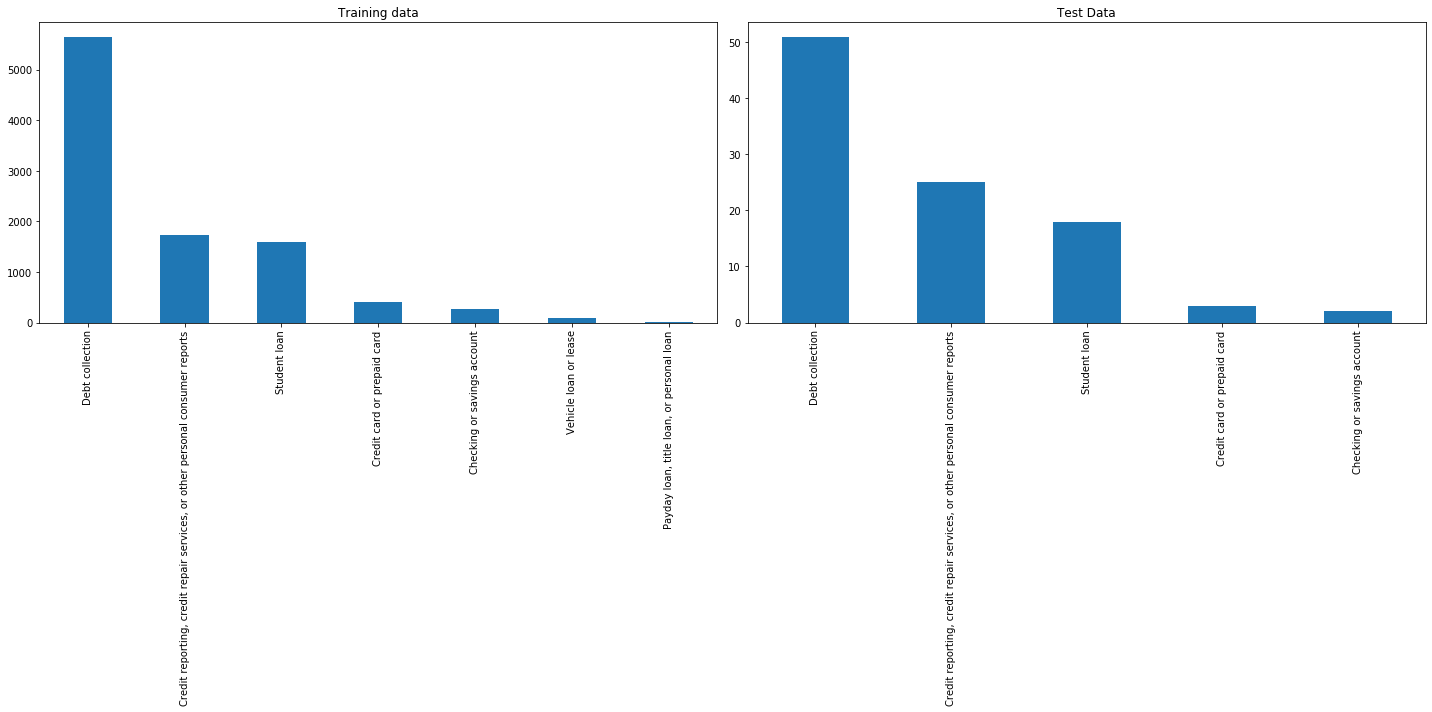

In [62]:
fig, axes = plt.subplots(nrows=len(output_cols), ncols=2, figsize=(20, 10))
for idx, output_col in enumerate(output_cols):
    df_train[output_col].value_counts().plot(kind='bar', rot=90, title='Training data', 
                                             ax=axes[idx][0] if len(output_cols)!=1 else axes[0] )
    df_test[output_col].value_counts().plot(kind='bar', rot=90, title='Test Data',
                                           ax=axes[idx][1] if len(output_cols)!=1 else axes[1])
fig.tight_layout()

# STI REST Endpoints

The STI service can be accessed and controlled through REST endpoint.
Documentation can be found in the following link: https://help.sap.com/viewer/product/SERVICE_TICKET_INTELLIGENCE

## Subscription and Authentication

Now we are ready to train a model using the Service Ticket Intelligence API. This requires a valid subscription to the STI API.

Note: Update the values for `service url`, `uaa url`, `client id` and `client secret` in the config file `sti_config.ini`. This config file is placed one directory above this notebook. These values will be available in `service_keys` of your STI instance in the cloud foundry cockpit.

Now we will use functions from `sti_functions.py` to access STI's REST endpoints. Feel free to browse the source code of it to see what's happening under the hood.

In [2]:
import configparser
from pathlib import Path
import sys

sys.path.append("..")
import sti_functions

In [3]:
# import importlib
# importlib.reload(sti_functions)

In [4]:
STI_BASE_DIR = Path.cwd().parent
config_file_path = STI_BASE_DIR / 'sti_config.ini'

connection = sti_functions.get_connection_object(config_file=config_file_path)
sti = sti_functions.STIFunctions(connection)

## List models

Now lets do list model call using this python function to view all the models in this account

In [66]:
sti.list_models()

Getting new token from https://sti-test.authentication.sap.hana.ondemand.com/oauth/token
New token expires at 2020-06-09 16:34:37
Response time: 1584.426 ms


{'results': [{'business_object': 'ticket',
   'language': 'en',
   'model_id': ['aada667d0e384a63bf0cad43d88f3b81',
    'f1cead0633a44e32a449cf285b542adf',
    '2eb7e7c1b6684c238083f8a93a140138',
    '522e3730af304c43a25d18b8905d89f9',
    '63689c91793145a780e482682aa525f2',
    'a3177cf70fec4705bfb6839bc0b30636',
    '416c46992bc74920832106eda95255a0',
    '8d1145c3d94a44ceb3d6cae8bdee14a3',
    '8c99a13d405948de82e9ccdf4f9ada17',
    '8b5a8ef24966450bb8b4c08d6622ef94',
    '3616e94d85d54fd890d2f1bd03ac61fe',
    'fe5b0ba4a99649668b0e9ba36e466044',
    'd7f104a02d2f4e8cbc6b074aef519268',
    'cc078a539d6a433a92f0ac0a2fb445d2',
    '8d62dbfd0e3043e5a16928190c8f965f'],
   'type': 'classification'},
  {'business_object': 'ticket',
   'language': 'en',
   'model_id': ['41932214b9a74aa3949824cc527a4fb2',
    '3c086206ddbb4a6081c171ac5ab447d3',
    '3de6092ddba945209c0fbe8fe83ef4ee',
    'e0477c0ec4844fdab0848547e3079b28'],
   'type': 'recommendation'},
  {'business_object': 'ticket',
   'l

### Let's check if we need to delete any unused model
Based on the model list above, ensure that the number of models does not exceed 20. Otherwise, we need to delete some unused model.

In [70]:
# sti.delete_model("8c99a13d405948de82e9ccdf4f9ada17")

## File upload

This process will take a few minutes to complete depending on the file size. If file upload is successful, the response text will contain a model id - an UUID identifier which we can use as a reference to the uploaded training file.

In [71]:
df_train_base64 = base64.b64encode(df_train.to_csv(index=False).encode('utf-8'))
payload = {
    "scenario":
      {
          "desc":"Complaint data for classification",
          "type":"classification",
          "language":"en",
          "business_object":"ticket"
      },
      "mapping":
      {
            "input": input_cols,
            "output": output_cols
      },
      "training":
      {
            "file": "{}".format(df_train_base64.decode('utf-8'))
      }
}
response = sti.file_upload(payload)
payload = {}
our_model_id = response.get('model_id')
response

Returning token from cache
Response time: 58803.643000000004 ms


{'business_object': 'ticket',
 'combined_accuracy': 0.0,
 'desc': 'Complaint data for classification',
 'disabled_category_class': [{'category_class': [], 'field': 'Product'}],
 'enabled_category_class': [{'category_class': ['Checking or savings account',
    'Debt collection',
    'Credit reporting, credit repair services, or other personal consumer reports',
    'Student loan',
    'Credit card or prepaid card',
    'Vehicle loan or lease'],
   'field': 'Product'}],
 'excluded_category_class': [{'category_class': ['Payday loan, title loan, or personal loan'],
   'field': 'Product',
   'reason': 'Not enough samples for training'}],
 'extracted_input': [{'field': 'Description', 'type': 'str'}],
 'extracted_output': [{'distribution': [{'count': 273,
     'value': 'Checking or savings account'},
    {'count': 5650, 'value': 'Debt collection'},
    {'count': 1730,
     'value': 'Credit reporting, credit repair services, or other personal consumer reports'},
    {'count': 1589, 'value': 'S

Note that the model status is new now. Once we submit training the `model_status` will transition from `NEW` -> `PENDING_TRAINING` -> `IN_TRAINING` -> `READY`

## Start training on uploaded file

Take the model id from file upload response text and pass it when in starting the model training

In [72]:
# our_model_id = "a33807253a204ba5a2f6192a45b727d6"
sti.start_model_training(model_id=our_model_id)

Returning token from cache
Response time: 3004.518 ms


{'language': 'en',
 'model_id': 'e16b7677bb3d4e339716317854c74864',
 'status': 0,
 'status_message': 'ok'}

## Wait for training to succeed

After starting the model training, do a get model status and check if model status is `READY`

The model status transitions from `NEW` to `PENDING_TRAINING` once training is submitted and will further transition to `IN_TRAINING` and finally `READY` when training succeeds

In [75]:
# our_model_id = "cc078a539d6a433a92f0ac0a2fb445d2"
status = sti.get_model_status(model_id=our_model_id)
print("Model status: {}".format(status.get('model_status')))

Getting new token from https://sti-test.authentication.sap.hana.ondemand.com/oauth/token
New token expires at 2020-06-09 19:08:33
Response time: 974.132 ms
Model status: READY


Wait for model status to be `READY` before proceeding to next step. This will take upto 10-20 mins from the training submission time. Repeatedly run the above cell to get the latest model status

Once the model status is `READY` proceed to next step.

## Model accuracy

The model accuracy, confusion matrics and other metrics (such as f1, precision etc.,) can be retrived once training is completed and status becomes ready

In [76]:
# our_model_id = "cc078a539d6a433a92f0ac0a2fb445d2"
status = sti.get_model_status(model_id=our_model_id)
print("Model combined accuracy:", status["combined_accuracy"])

Returning token from cache
Response time: 877.572 ms
Model combined accuracy: 0.8737980723381042


In [77]:
# our_model_id = "cc078a539d6a433a92f0ac0a2fb445d2"
accuracy = sti.get_model_accuracy(model_id=our_model_id)
for idx, result in enumerate(accuracy["validation_results"]):
    print("\nField:", accuracy["validation_results"][idx]["field"])
    print("Model average f1 score:", accuracy["validation_results"][idx]["average_f1_score"])
    print("Model average precision:", accuracy["validation_results"][idx]["average_precision"])
    print("Model average recall:", accuracy["validation_results"][idx]["average_recall"])

Returning token from cache
Response time: 860.1569999999999 ms

Field: Product
Model average f1 score: 0.8645931420444415
Model average precision: 0.8705323552858558
Model average recall: 0.8737980769230769


We can plot the confusion matrix as well to visually see the performance of the model

Returning token from cache
Response time: 846.835 ms
Confusion matrix, without normalization


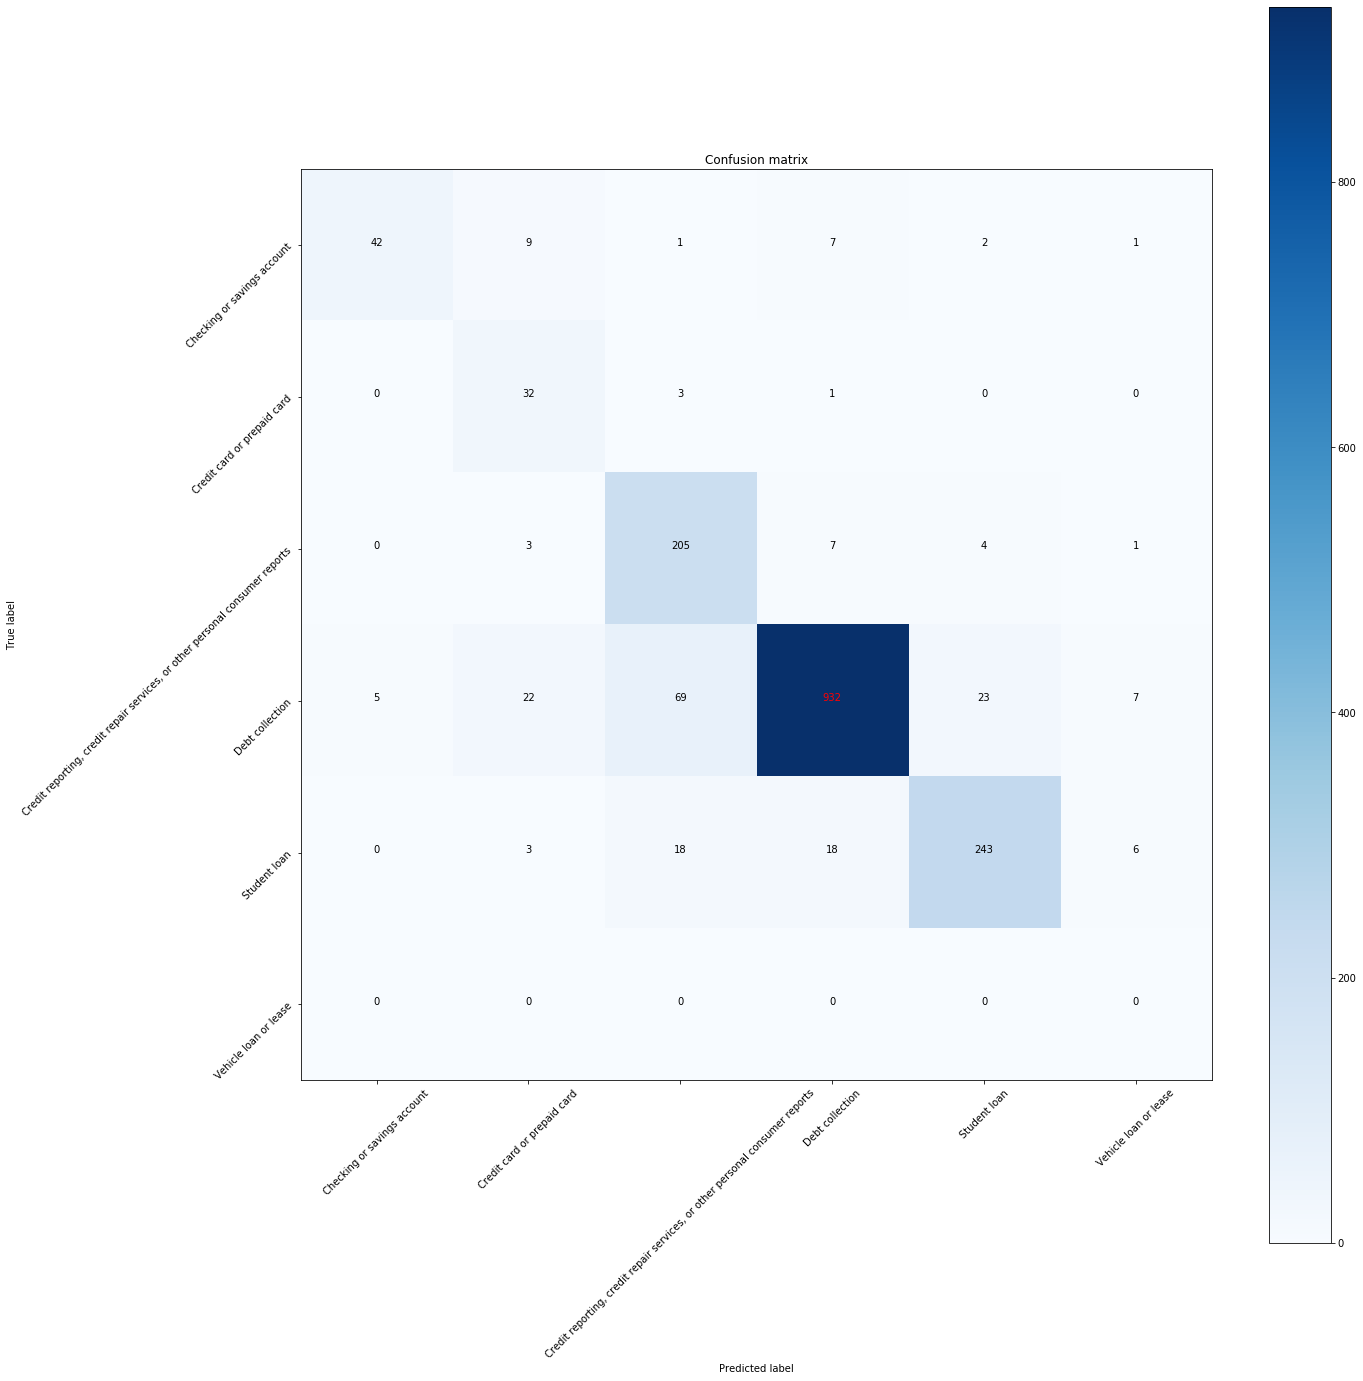

In [78]:
sti.plot_confusion_matrix(model_id=our_model_id)

## Activate the model

Once you are satisfied with the results, model needs to activated before inference can be run on

In [79]:
sti.activate_model(model_id=our_model_id)

Returning token from cache
Response time: 897.8580000000001 ms


{'model_id': 'e16b7677bb3d4e339716317854c74864',
 'status': 0,
 'status_message': 'ok'}

## Build inference payload and send request

We will select a random example from our `df_test` dataframe which has not been sent for training and evaluate how the model performs

In [80]:
df_test.iloc[8]

Description    I signed up with XXXX XXXX XXXX about 3 years ...
Product                                          Debt collection
Name: 8370, dtype: object

In [81]:
payload = {}
payload["business_object"] = "ticket"
payload["messages"] = [{"id": 2001, "contents": []}]
for input_col in input_cols:
    payload["messages"][0]['contents'].append({"field": input_col, "value": df_test.iloc[8][input_col]})
    
inference_response = sti.classify_text(payload)
inference_response

Returning token from cache
Response time: 3648.0679999999998 ms


{'results': [{'classification': [{'confidence': 0.9729096293449402,
     'field': 'Product',
     'value': 'Debt collection'}],
   'detected_language': 'en',
   'id': 2001,
   'status': 0,
   'status_message': 'ok'}]}

You can explore around by giving different input from `df_test` or your own input and see how the model performs

## Lets evaluate the STI model performance ourselves

We also can run inference against all the data from `df_test` and evaluate by ourselves how the sti model performs. We will results from STI against the original value of the `df_test`

In [82]:
payload = {
    "business_object": "ticket",
    "messages": []
}
for index, row in df_test.iterrows():
    tmp = {'id': index, 'contents': []}
    for input_col in input_cols:
        tmp['contents'].append({"field": input_col, "value": row[input_col]})

    payload['messages'].append(tmp)

inference_response = sti.classify_text(payload)

Returning token from cache
Response time: 22345.251999999997 ms


In [47]:
inference_response

{'results': [{'classification': [{'confidence': 0.9981388449668884,
     'field': 'Product',
     'value': 'Credit reporting, credit repair services, or other personal consumer reports'},
    {'confidence': 0.9816488027572632,
     'field': 'Sub-product',
     'value': 'Credit reporting'}],
   'detected_language': 'en',
   'id': 4051,
   'status': 0,
   'status_message': 'ok'},
  {'classification': [{'confidence': 0.9996929168701172,
     'field': 'Product',
     'value': 'Debt collection'},
    {'confidence': 0.7396916151046753,
     'field': 'Sub-product',
     'value': 'Medical'}],
   'detected_language': 'en',
   'id': 2740,
   'status': 0,
   'status_message': 'ok'},
  {'classification': [{'confidence': 0.9221192598342896,
     'field': 'Product',
     'value': 'Credit reporting, credit repair services, or other personal consumer reports'},
    {'confidence': 0.8610331416130066,
     'field': 'Sub-product',
     'value': 'Credit reporting'}],
   'detected_language': 'en',
   'id':

In [83]:
from sklearn.metrics import classification_report
y_true_collection = []
y_pred_collection = []
for idx, output_col in enumerate(output_cols):
    y_true = [row[output_col] for _, row in df_test.iterrows()]
    y_pred = [classification['classification'][idx]['value'] for classification in inference_response['results']]
    assert(len(y_true) == len(y_pred))
    y_true_collection.append(y_true)
    y_pred_collection.append(y_pred)
    print(classification_report(y_true, y_pred))

                                                                              precision    recall  f1-score   support

                                                 Checking or savings account       0.67      1.00      0.80         2
                                                 Credit card or prepaid card       1.00      0.67      0.80         3
Credit reporting, credit repair services, or other personal consumer reports       1.00      0.44      0.61        25
                                                             Debt collection       0.80      1.00      0.89        51
                                                                Student loan       0.84      0.89      0.86        18

                                                                    accuracy                           0.83        99
                                                                   macro avg       0.86      0.80      0.79        99
                                                      

Returning token from cache
Response time: 1424.133 ms
Confusion matrix, without normalization


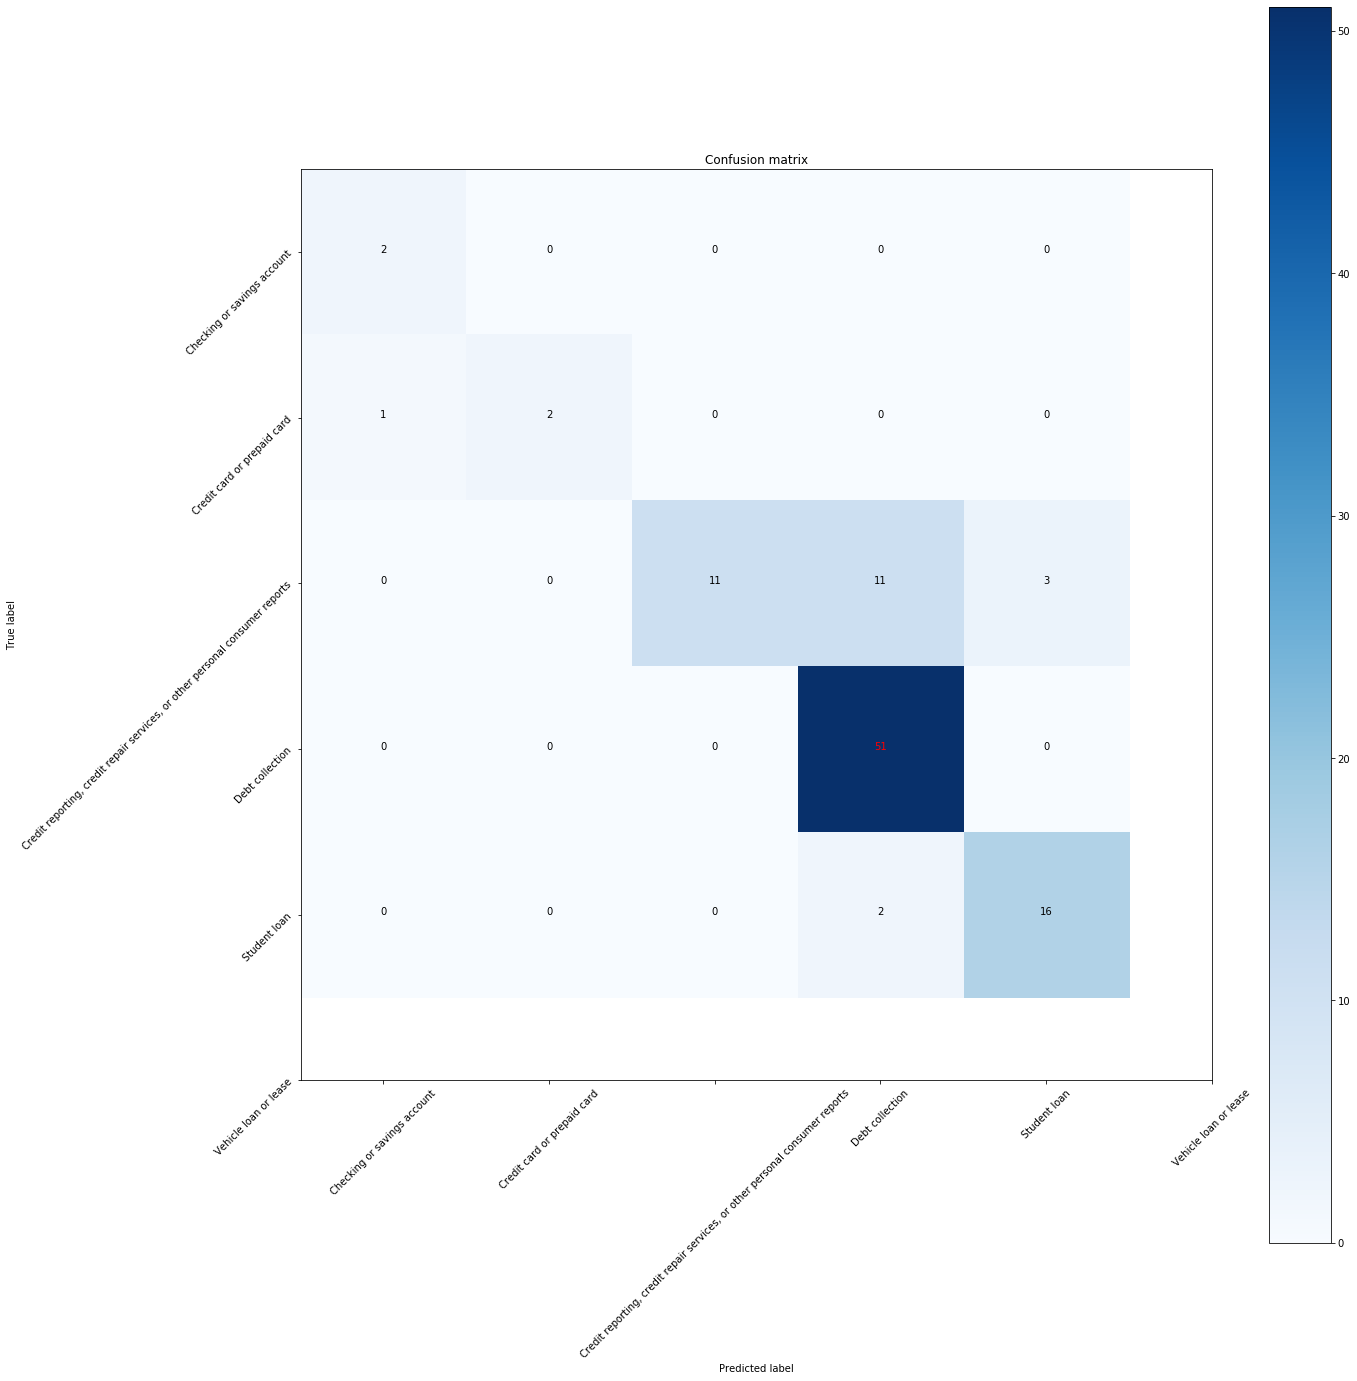

In [84]:
model_results = sti.get_model_accuracy(model_id=our_model_id)
for idx, (y_true, y_pred) in enumerate(zip(y_true_collection, y_pred_collection)):
    fig = plt.figure(figsize=(20,20))
    cnf_mtrx = confusion_matrix(y_true, y_pred)
    sti_functions.plot(cnf_mtrx, 
                       classes=model_results["validation_results"][idx]["confusion_matrix"]["labels"], 
                       title='Confusion matrix')

# Using STI's pre-trained models

Apart from building custom models with your own data, STI also provides pre-trained models for sentiment analysis and language detection.

## Language Detection

You can use this to detect the language of text.
ISO Language codes of message content will be shown in response

In [5]:
payload = {
    "business_object": "ticket",
    "messages": [
        {
            'id': 2001,
            'contents': [
                {
                    'field': input_cols[0],
                    'value': "I don't like your service"
                }
            ]
        },
        {
            'id': 2002,
            'contents': [
                {
                    'field': input_cols[0],
                    'value': 'Ich mag deinen Service nicht'
                }
            ]
        }
    ],
    "options": {
        "services": {
            "detect_language": True
        }
    }
}
inference_response = sti.classify_text(payload)
inference_response

Getting new token from https://sti-test.authentication.sap.hana.ondemand.com/oauth/token
New token expires at 2020-06-25 17:52:26
Response time: 838.2239999999999 ms


{'results': [{'detected_language': 'en',
   'id': 2001,
   'status': 0,
   'status_message': 'ok'},
  {'detected_language': 'de',
   'id': 2002,
   'status': 0,
   'status_message': 'ok'}]}

## Sentiment Analysis

Provides sentiment score of the input content ranging from -1 to 1. Highly negative sentiment will have score of -1 and highly positive sentiment will have a score of +1. And 0 may denote a neutral phrase

In [6]:
payload = {
    "business_object": "ticket",
    "messages": [
        {
            'id': 2001,
            'contents': [
                {
                    'field': input_cols[0],
                    'value': "I don't like your service"
                }
            ]
        },
        {
            'id': 2002,
            'contents': [
                {
                    'field': input_cols[0],
                    'value': 'Ich mag deinen Service nicht'
                }
            ]
        }
    ],
    "options": {
        "services": {
            "detect_sentiment": True
        }
    }
}
inference_response = sti.classify_text(payload)
inference_response

Returning token from cache
Response time: 2223.458 ms


{'results': [{'id': 2001,
   'sentiment': {'overall_score': -0.9},
   'status': 0,
   'status_message': 'ok'},
  {'id': 2002,
   'sentiment': {'overall_score': -0.5},
   'status': 0,
   'status_message': 'ok'}]}

## Multiple services in same request.

You can request one inference request to do category classification and sentiment analysis.

In [7]:
payload = {
    "business_object": "ticket",
    "messages": [
        {
            'id': 2001,
            'contents': [
                {
                    'field': input_cols[0],
                    'value': "I don't like your service"
                }
            ]
        }
    ],
    "options": {
        "services": {
            "detect_category": True,
            "detect_sentiment": True,
            "detect_language": True,
        }
    }
}
inference_response = sti.classify_text(payload)
inference_response

Returning token from cache
Response time: 1853.44 ms


{'results': [{'classification': [{'confidence': 0.5562902688980103,
     'field': 'Product',
     'value': 'Debt collection'}],
   'detected_language': 'en',
   'id': 2001,
   'sentiment': {'overall_score': -0.9},
   'status': 0,
   'status_message': 'ok'}]}

## Deactivate model

We can deactivate any active models here.

In [29]:
# sti.deactivate_model(model_id="")

## Delete model

We can delete any unused models here.

In [30]:
# sti.delete_model(model_id="")